# Continually Learning Prototypes (CLP) with Lava

**Motivation**: This tutorial demonstrates how Lava users can define and
implement a version of the CLP algorithm which can detect novel patterns and
learn these in a one-shot manner. CLP is the successor of the neuromorphic
prototype-based continual learning algorithm we have developed for Loihi 1.
For more information on this precursor algorithm:

[Interactive continual learning for robots: a neuromorphic approach](https://dl.acm.org/doi/abs/10.1145/3546790.3546791 "Interactive continual learning for robots: a neuromorphic approach")

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")
- are familiar with how to [implement a reward-modulated learning rule](../../in_depth/three_factor_learning/tutorial01_Reward_Modulated_STDP.ipynb "Tutorial on R-STDP")


This tutorial demonstrates how the basic blocks of the CLP algorithm
implemented as Lava processes can be connected to perform novelty detection
and one-shot learning. We will instantiate 4 main processes, namely
PrototypeLIF,  NoveltyDetector, LearningDense & Readout. We then demonstrate
how these processes can be connected to create a simple version of the CLP
algorithm.


## Introduction to CLP

### Online Continual Learning with Open-set Recognition

The problem we are trying to solve can be seen as a combination of multiple complex tasks. 

- First and foremost we want to achieve continual learning of classes over time, where the data is available as a stream and we cannot iterate over or store this data. This setting is known as online continual learning (Figure 1). Online (on-fly) learning requirement points us to Loihi's on-chip learning engine.

- Learning continually in the wild requires detecting novel patterns and learning them fast. As we may have only one or few instances of the new class, we need to learn it fast and ideally in a one-shot manner. This brings us to the next two requirements: novelty detection and one-shot learning 

- Finally, we want our system to be able to perform open-set recognition, i.e. rather than performing recognition purely on the known classes (close-set recognition), we also want to recognize instances from unknown classes (Figure 3, [Shu et al. 2020](https://www.nature.com/articles/s41598-020-63649-6 "P-ODN: Prototype-based Open Deep Network for Open Set Recognition")). For this purpose, we will use prototypes with a radius (or margin) of recognition defined around them (Figure 2). In terms of the spiking (LIF) neurons, this margin translates to the voltage threshold for spiking. 

<center><img src="../../in_depth/clp/images/continual_learning.png" style="width:70%"><center>
<center><figcaption align = "center"> Figure 1. Continual Learning (image credit: Matthias De Lange)</figcaption><center>

<br/><br/>
    
<center><img src="../../in_depth/clp/images/knn_clp.jpg" style="width:50%"><center>
<center><figcaption align = "center"> Figure 2. The concept of prototypes in the brain. (Left) Learning by hard all examples is akin to k-NN. (Right) Learning an abstract concept from the seen examples is the idea behind the prototypes and what CLP uses</figcaption><center>
    
<br/><br/>
    
<img src="../../in_depth/clp/images/open_set_recognition.png" style="width:100%">
<center><figcaption align = "center"> Figure 3. Open-set recognition </figcaption><center>


### Similarity Measure: Why Cosine Similarity?

The prototype-based methods generally use Euclidean distance as the similarity measure. However, in high-dimensional space, the Euclidean distance starts to lose its meaning because of the curse of dimensionality. In addition, calculating the Euclidean distance requires types of operations (vector length, squaring) that are not supported on Loihi or are just not local computations. The cheapest operation available in Loihi is the dot product between the input spikes and the weights. We can efficiently compute this dot product, especially with the graded spikes in Loihi 2. However, the dot product is not a reliable similarity measure as long as the vectors have different lengths. Therefore, we will normalize all input vectors and inject them as graded spikes. As the weights are learned from these inputs, they are also normalized. Consequently, the dot product between inputs and weights corresponds to the cosine similarity between the non-normalized original input and the normalized weights. These stored weights are the learned prototypes. 

From the literature, we know that cosine similarity works well for high-dimensional spaces ([Hersche et al. 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/Hersche_Constrained_Few-Shot_Class-Incremental_Learning_CVPR_2022_paper.pdf)). As our main problem domain is visual processing, which generally has high-dimensional input, implicitly using cosine-similarity fits our purposes. Implicitly because we arrive at cosine similarity using the dot-product of normalized vectors. From the CLP's perspective, it still performs a dot product similarity. This will play an essential role in deriving the learning rules and interpreting the similarity measure.

In Figure 4, we see prototypes with some recognition margin around them. On the left panel, a prototype with Euclidean similarity defines a point in Euclidean space and a circle in 2D (or a sphere in 3D) with a given radius (i.e., recognition threshold) around it. On the middle panel, we the prototype vectors with cosine similarity. In this case, both input and prototype vectors can have different lengths: the similarity is measured as the angle between the input vector and the weight vectors. Hence the recognition margins are circular and spherical sectors in 2D and 3D, respectively. On the right panel, we see our case: all input and weight vectors are normalized, i.e., they fall on the surface of a hyper-sphere. The recognition margins are defined solely on this surface: an arc of a circle in 2D and a piece (cap) on the sphere's surface. Therefore, CLP will perform its computation always on this kind of surface.


<center> <img src="../../in_depth/clp/images/sim_measure_and_protos.png" style="width:70%"><center> 
<br/><br/>
<center><figcaption align = "center"> Figure 4. Prototypes with different similarity measures in 2D and 3D. (a) Euclidean distance/similarity, (b) cosine similarity, (c) Dot product similarity on normalized vectors. Figures are adopted from [Liu et al. 2017].   </figcaption><center> 
<br/><br/>
    
References:
[Zhu et al. 2022](https://link.springer.com/article/10.1007/s11432-021-3316-x "Low-time-complexity document clustering using memristive dot product engine"), [Liu et al. 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Liu_SphereFace_Deep_Hypersphere_CVPR_2017_paper.pdf "SphereFace: Deep Hypersphere Embedding for Face Recognition") 

    

## CLP in Lava

In [1]:
import numpy as np
import typing as ty
import matplotlib.pylab as plt
from lava.magma.core.learning.constants import GradedSpikeCfg

from lava.utils.weightutils import SignMode

from lava.magma.core.learning.learning_rule import Loihi3FLearningRule

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.clp.prototype_lif.process import PrototypeLIF
from lava.proc.clp.novelty_detector.process import NoveltyDetector
from lava.proc.clp.nsm.process import Readout
from lava.proc.io.source import RingBuffer, PySendModelFixed
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense, LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

#### Data generation and visualization

Let's generate some synthetic data samples in 2D from two clusters (i.e., classes) with different angled centers (remember, we will use implicit cosine similarity to distinguish classes). We will then normalize all the data vectors to length 1 to construct our input vectors

In [2]:
from sklearn.datasets import make_blobs

n_samples = 15
n_clusters = 3
random_state = 54
v_min = 0
v_max = 2

# Generate synthetic data
X, y = make_blobs(
    n_samples=n_samples, centers=np.array([[0.7, 0.7], [0.5, 1.6], [1.7, 0.3]]), cluster_std=[0.07, 0.07, 0.07], random_state=random_state
)  

y = y + 1  # the label==0 is reserved for no information on communication channel
cluster_ids = y.copy()
y[y==3] = 2
# Normalize the vectors
inp_pattern = X / np.expand_dims(np.linalg.norm(X,axis=1), axis=1)

In [3]:
print("Cluster id of each input pattern:", cluster_ids)
print("Label of each input pattern:     ", y)

Cluster id of each input pattern: [1 1 2 2 3 2 3 1 2 3 3 1 2 3 1]
Label of each input pattern:      [1 1 2 2 2 2 2 1 2 2 2 1 2 2 1]


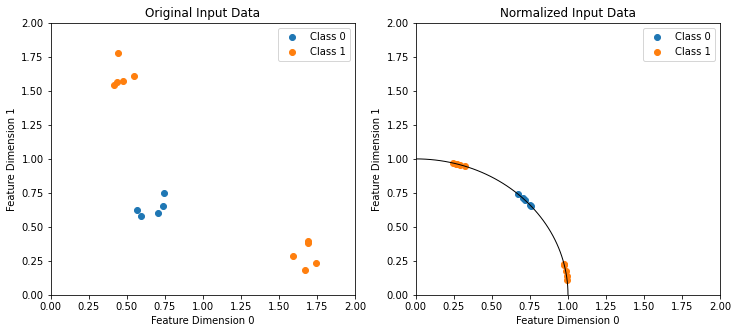

In [4]:
fig, axes = plt.subplots(figsize=(12,5),nrows=1, ncols=2)
plt.sca(axes[0])
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class 0")
plt.scatter(X[y==2, 0], X[y==2, 1], label="Class 1")

plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("Feature Dimension 0")
plt.ylabel("Feature Dimension 1")
plt.title("Original Input Data")
plt.legend()

plt.sca(axes[1])
plt.scatter(inp_pattern[y==1, 0], inp_pattern[y==1, 1], label="Class 0")
plt.scatter(inp_pattern[y==2, 0], inp_pattern[y==2, 1], label="Class 1")

plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("Feature Dimension 0")
plt.ylabel("Feature Dimension 1")

theta = np.linspace(0,np.pi*0.5)
plt.plot(np.cos(theta), np.sin(theta), linewidth=1, c='k')
plt.title("Normalized Input Data")

plt.legend()
plt.show()

In the left panel of the above figure, we see that the original vectors have different lengths and are scattered in the 2D space. The normalized data on the right panel falls on the unit circle (note the similarity to Figure 4-(c) upper panel). Below we plot the dot product similarity between the  normalized patterns.

[1 1 2 2 2 2 2 1 2 2 2 1 2 2 1]


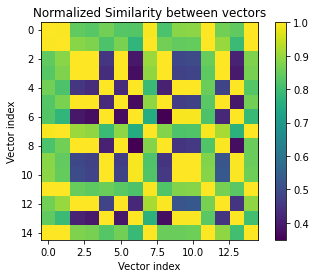

In [5]:
sims = np.dot(inp_pattern, inp_pattern.T)
plt.figure()
plt.imshow(sims)
plt.colorbar()
plt.title("Normalized Similarity between vectors")
plt.xlabel("Vector index")
plt.ylabel("Vector index")
print(y)

### Neural and Process Diagram

<center><img src="../../in_depth/clp/images/neural_diagram.png" style="width:70%"><center> 
<center><figcaption align = "center"> Figure 5. CLP Diagram.  </figcaption><center> 
<br/><br/>
    
This first version of CLP includes the features like novelty detection, one-shot learning, and supervised and unsupervised labeling of the learned prototypes. The normalized input vectors are one-by-one injected into the prototype neurons through prototype weights/synapses. Suppose none of the prototype neurons spike after the input injection. In that case, this is detected by the novelty detector via coincidence detection between the presence of the input and the absence of any output. Once this is detected, the novelty detector sends a strong third-factor signal to the prototype population. It aims explicitly at the unallocated neuron in this population. As a result, this prototype neuron learns the input in one shot, effectively memorizing the input as a prototype. The outputs of prototype neurons are sent to the Readout module, which interprets the prototype index as a prediction label. Note that one class may have more than one prototype. Therefore, the Readout module keeps a dictionary that maps the prototype ids to the labels. I,f during the one-shot allocation process, a user provides a label to the Readout module. This label will label the newly allocated prototype's id. If the user provides no label, the newly allocated neuron will get a unique pseudo-label so that the system can later identify other instances from this class as "unknown class x". This is precisely what  open-set recognition tries to achieve (Figure 3). If alter the actual label is provided together with an instance from this unknown class, the Readout module automatically changes the pseudo-label to this actual label. 

All these modules are implemented as processes in Lava (Figure 6): PrototypeLIF, NoveltyDetector, and Readout. The input process is connected to the PrototypeLIF process via a LearningDense process - a dense connection of plastic synapses. To understand the learning setup and connections, we refer the reader to the following tutorial on [the reward-modulated learning rule](../../in_depth/three_factor_learning/tutorial01_Reward_Modulated_STDP.ipynb "Tutorial on R-STDP"). 

The system described in Figure 6 runs on a CPU, though with the Loihi protocol. The Loihi 2 implementation will be coming soon.

<center><img src="../../in_depth/clp/images/lava_diagram.png" style="width:90%"><center> 
<center><figcaption align = "center"> Figure 6. CLP Lava Diagram.  </figcaption><center> 
<br/><br/>
    

### Parameter and network initialization

Let's first set the parameters for all the processes. 

In [6]:
# General params
t_wait = 4  # the waiting window for novelty detection after input injection
n_protos = 3  # number of the prototypes
n_features = 2  # the feature dimension of the input
b_fraction = 8  # The fraction of the fixed point representation used to translate floating point input to graded spikes

n_steps_per_sample = 10  # The time difference between two consecutive inputs
num_steps = (n_samples+1) * n_steps_per_sample  # number of time steps that the processes will run

# PrototypeLIF neural dynamics parameters
du = 4095
dv = 4095
vth = 63500

# Learning rule parameters
x1_tau = 65535  # Pre-trace decay constant. The high values means no decay
t_epoch = 1  # Epoch length

# Config for writing graded payload of the input spike to x1-trace
graded_spike_cfg = GradedSpikeCfg.OVERWRITE

We initialize all prototype weights to zero. This means none of the prototypes are allocated, i.e., free.

In [7]:
# No pattern is stored yet. None of the prototypes are allocated
weights_proto = np.array([[0, 0], [0, 0], [0, 0]])

# Weights also should be in the fixed point representation if starting with some non-zero weights.
weights_proto = weights_proto * 2 ** b_fraction

Here we set the connection weights to the inputs of the ``NoveltyDetector``

In [8]:
# Novelty detection input connection weights  (all-to-one connections)
weights_in_aval = np.ones(shape=(1, n_features))
weights_out_aval = np.ones(shape=(1, n_protos))

### Generate input and user label spikes
Next, we need to create spike patterns for the input process that will inject the input patterns into the prototype population. We will inject the patterns periodically every ``n_steps_per_sample``

In [9]:
# The graded spike array for input
s_pattern_inp = np.zeros((n_features, num_steps))

# Convert normalized input patterns to 8-bit fixed-point patterns
inp_pattern_fixed = (inp_pattern * 2 ** b_fraction).astype(np.int32)

# Create input spike pattter that inject these inputs every n_steps_per_sample time step
s_pattern_inp[:,1:-n_steps_per_sample:n_steps_per_sample] = inp_pattern_fixed.T

Let's also define when and which labels will be provided to the network

In [10]:
# The graded spike array for the user-provided label 
s_user_label = np.zeros((1, num_steps))

s_user_label[0,9] = 1
s_user_label[0,27] = 2
s_user_label[0,97] = 2

### Defining the local learning rule for CLP
Next, we need to define the learning rule for the plastic synapses of the prototype neurons. Currently, we support only one-shot learning for prototypes, where they learn the input pattern detected as a novel pattern in a one-shot manner and then do not update. The adaptive prototypes that can adapt after the initial learning will be introduced in the next release. 

The learning rule capable of one-shot learning should write the input to the weights. So mathematically, the rule would look like the following: 

$\Delta w = \alpha * x $

In Loihi's learning engine formulation, this rule would look like this:

$dw = y_1 * x_1 $

We want to apply this learning rule update when receiving a novelty detection signal. For this purpose, we can use the gating variables of the learning engine. Specifically, we will use $y_0$, a programmable post-synaptic gating variable. We assign the incoming novelty detection signal to $y_0$ in the process model of the ``PrototypeLIF`` process.

$dw = y_1 * x_1 * y_0 $

Finally, because of the limited bit-accuracy of the product accumulators of the learning engine, the multiplication between $y_1$ and $x_1$ will be shifted right by two bits. In addition, during writing, the input spike-graded payload to the x-trace also shifts the graded value by one bit. So in total, we need to left-shift by 3 bits. On the other hand, while converting the multiplication of two 7-bit traces to an 8-bit weight, we need to shift right by 6 bits (7+7-8=6). When we put together a 6-bit right shift and a 3-bit left shift, we get a 3-bit right shift. This will be our constant ``k``.

$dw = k * y_1 * x_1 * y_0 $

In [11]:
# Create a custom LearningRule. Define dw as a string
dw = "2^-3*y1*x1*y0"

learning_rule = Loihi3FLearningRule(dw=dw,
                                    x1_tau=x1_tau,
                                    t_epoch=t_epoch)

### Initialize Network Processes
Now we can initialize all the processes in the Figure 6 and make the necessary connections

In [12]:
# Processes
data_input = RingBuffer(data=s_pattern_inp)

user_label_input = RingBuffer(data=s_user_label)

nvl_det = NoveltyDetector(t_wait=t_wait,
                          n_protos=n_protos)

readout_layer = Readout(n_protos=n_protos,
                        proto_labels=np.zeros((1,n_protos)))

# Prototype Lif Process
prototypes = PrototypeLIF(du=du,
                          dv=dv,
                          bias_mant=0,
                          bias_exp=0,
                          vth=vth,
                          shape=(n_protos,),
                          name='lif_prototypes',
                          sign_mode=SignMode.EXCITATORY,
                          learning_rule=learning_rule)

dense_proto = LearningDense(weights=weights_proto,
                            learning_rule=learning_rule,
                            name="proto_weights",
                            num_message_bits=8,
                            graded_spike_cfg=graded_spike_cfg)

# Incoming (Dense) connection processes for NoveltyDetector
dense_in_aval = Dense(weights=weights_in_aval)
dense_out_aval = Dense(weights=weights_out_aval)

# Monitor processes
monitor_nvl = Monitor()
monitor_protos = Monitor()
monitor_weights = Monitor()
monitor_preds = Monitor()

#### Process Connections

In [13]:
# Connections

# Data input -> PrototypeLIF connection
data_input.s_out.connect(dense_proto.s_in)
dense_proto.a_out.connect(prototypes.a_in)

# Data input -> NoveltyDetector connection for input_available signal
data_input.s_out.connect(dense_in_aval.s_in)
dense_in_aval.a_out.connect(nvl_det.input_aval_in)

# PrototypeLIF -> NoveltyDetector connection for output_available signal
prototypes.s_out.connect(dense_out_aval.s_in)
dense_out_aval.a_out.connect(nvl_det.output_aval_in)

# Novelty detector to prototypes connection
nvl_det.novelty_detected_out.connect(prototypes.a_third_factor_in)

# lif_prototypes.s_out.connect(proto_weights_dense.s_in_bap)
prototypes.s_out_bap.connect(dense_proto.s_in_bap)

# Sending y1 spike
prototypes.s_out_y1.connect(dense_proto.s_in_y1)

# Prototype Neurons' outputs connect to the inference input of the Readout process
prototypes.s_out.connect(readout_layer.inference_in)
user_label_input.s_out.connect(readout_layer.label_in)

### Create Probes

In [14]:
# Probe novelty detector and prototypes
monitor_nvl.probe(target=nvl_det.novelty_detected_out, num_steps=num_steps)
monitor_protos.probe(target=prototypes.s_out, num_steps=num_steps)
monitor_preds.probe(target=readout_layer.user_output, num_steps=num_steps)
monitor_weights.probe(target=dense_proto.weights, num_steps=num_steps)

We will run the ``PrototypeLIF``, ``LearningDense``, and ``Dense`` processes with their Loihi bit-approximate process models that as the name suggests, approximate the Loihi's computation. The other processes - ``NoveltyDetector``, ``Readout``, and ``RingBuffer`` will run a fixed-point Python code without any Loihi dynamics. 

### Run the Network

In [15]:
# Run
exception_map = {
    LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

# Get results
novelty_spikes = monitor_nvl.get_data()
novelty_spikes = novelty_spikes[nvl_det.name][
    nvl_det.novelty_detected_out.name]

proto_spikes = monitor_protos.get_data()
proto_spikes = proto_spikes[prototypes.name][prototypes.s_out.name]

preds = monitor_preds.get_data()[readout_layer.name][readout_layer.user_output.name]

result_weights = monitor_weights.get_data()
result_weights = result_weights[dense_proto.name][
    dense_proto.weights.name]

# Stop the run
prototypes.stop()


### Visualizing the learning results

In [16]:
from utils import plot_spikes, plot_time_series, plot_multiple_time_series, plot_spikes_time_series

#### Network Outputs: Novelty Detection, Prototypes, Predictions, Labeling

In [17]:
def plot_spikes_time_series(time, time_series, spikes, figsize, legend,
                            colors, title, num_steps):

    offsets = list(range(1, len(spikes) + 1))
    num_x_ticks = np.arange(0, num_steps+1, 25)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(211)
    plt.eventplot(positions=spikes, 
                  lineoffsets=offsets,
                  linelength=0.9,
                  colors=colors[:-1])

    plt.title("Spike Arrival")
    plt.xlabel("Time steps")

    plt.xticks(num_x_ticks)
    plt.xlim(0, num_steps)
    plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
    plt.grid(which='major', color='lightgray', linewidth=0.8)
    plt.minorticks_on()
    
    plt.yticks(ticks=offsets, labels=legend)
    plt.tight_layout(pad=3.0)

    plt.subplot(212)
    plt.step(time, time_series, color=colors[-1])
   
    plt.title(title[0])
    plt.xlabel("Time steps")
    plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
    plt.grid(which='major', color='lightgray', linewidth=0.8)
    plt.minorticks_on()
    plt.margins(x=0)

    plt.ylabel("Trace Value")
    
    plt.show()

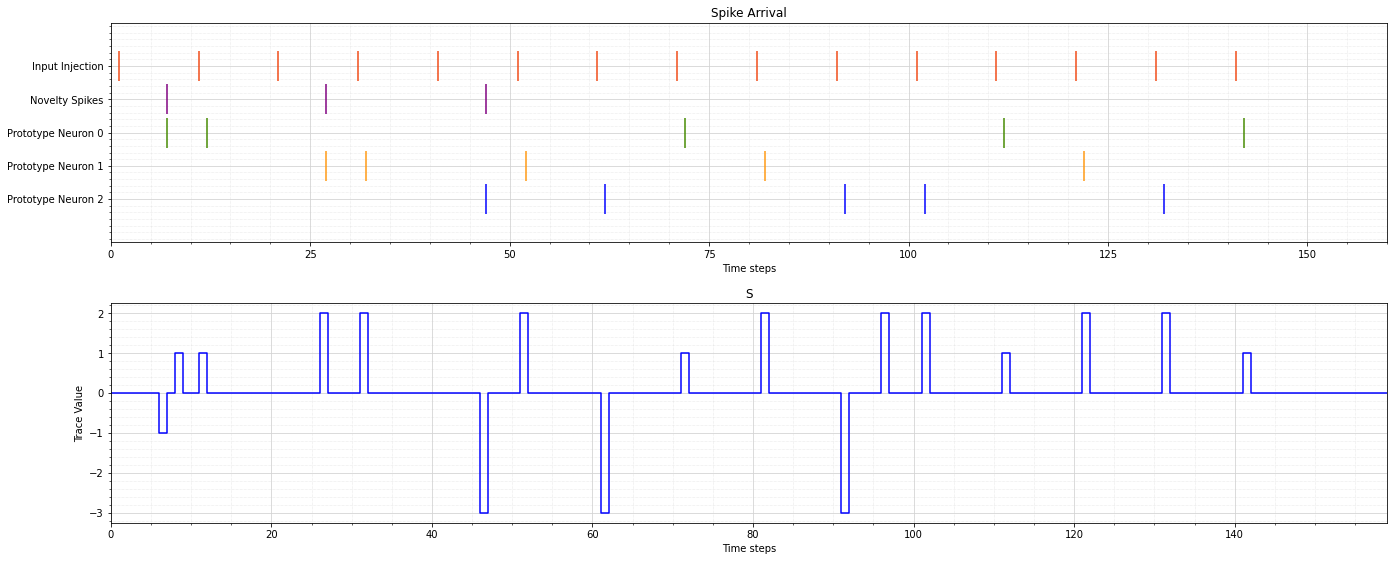

In [18]:
time = np.arange(num_steps)
plot_spikes_time_series(spikes=[np.where(proto_spikes[:, 2])[0], np.where(proto_spikes[:, 1])[0], np.where(proto_spikes[:, 0])[0], np.where(novelty_spikes[:, :])[0], np.where(s_pattern_inp[0, :])[0]],
                        time_series=preds,
                        time=time,
                        figsize=(20, 8),
                        legend=['Prototype Neuron 2', 'Prototype Neuron 1', 'Prototype Neuron 0', 'Novelty Spikes', 'Input Injection'], 
                        colors=['blue','#ff9912', '#458b00','purple', '#f14a16', 'blue'],
                        title='Spike Raster Plot',
                        num_steps=num_steps
                        )

Pattern ID | Cluster ID | True Label 
-----|-----|-----
 0 | 1 | 1 
 1 | 1 | 1 
 2 | 2 | 2 
 3 | 2 | 2 
 4 | 3 | 2 
 5 | 2 | 2 
 6 | 3 | 2 
 7 | 1 | 1 
 8 | 2 | 2 
 9 | 3 | 2 
10 | 3 | 2 
11 | 1 | 1 
12 | 2 | 2 
13 | 3 | 2 
14 | 1 | 1 

The upper plot in the above figure shows spike times for input, novelty detection, and all three prototype neurons. Inputs are injected in regular intervals. The lower plot visualizes the output of the Readout process, which translates the winner prototype id to predictions. The Readout process has versatile behavior: it can both support unsupervised and supervised learning and provide an interactive labeling interface. The user can intermittently give a supervision signal, i.e., the label. There are three cases covered in this current version:

- **User provides the label simultaneously with a novel input:** A new prototype neuron is allocated and directly labeled with this provided label (label>0).
- **A novel input is given without any label:** A new prototype neuron is allocated and labeled with a temporary, pseudo label (label<0).
- **User provides a label after a pseudo-label predicted by CLP:** The winner prototype's label, which had a pseudo-label, is updated to this new user-provided label 

In Figure 7 below, we analyze the network outputs in more detail.

Note that the cluster id and label of each pattern are shown in the table above (we started both cluster ids and labels from 1, as zero is reserved in communication channels of processes for the case of no signal).

Firstly, for some time steps (determined by the ```t_wait``` parameter) after the first input, the novelty detector spikes, as the system has not learned anything yet. This signal allocates the ```Prototype Neuron 0``` to learn that input pattern. No label is provided, so the label ```-1``` is assigned. A few steps later, the user provided a label ```1```  and updated this neuron's label. So ```Prototype Neuron 0``` has learned cluster 0. Hence this neuron responds to the second input, which is also from the same cluster (the second green spike), and Readout outputs the label ```1``` as expectedas expected

The 3rd input pattern is from cluster 1, and as expected, the novelty detector spikes again, allocating the ```Prototype Neuron 1```this time. However, the label is provided together this time, so the labeling of the newly allocated neuron happens immediately (with the label ```2```).  The next pattern is also from cluster 1, so the newly allocated neuron spikes and the correct label is predicted. 

Finally, the fifth input pattern is from an unsee cluster (cluster 2). Hence, a novelty spike follows it after some time and allocates the ```Prototype Neuron 2``` and has been assigned the pseudo-label ```-3```. All the next input patterns from this cluster are recognized as ```-3```. After one of those input patterns, the actual label (```3```) is provided so that the label of the ```Prototype Neuron 2``` is updated to ```3```. After that, the patterns from this cluster are predicted with the label ```3```. One can validate the correct prototype neuron spikes for each input by comparing it to the table above of the accurate cluster ids and labels.

<center><img src="../../in_depth/clp/images/readout_labeling_analysis.png" style="width:100%"><center> 
<center><figcaption align = "center"> Figure 7. Readout and labeling analysis.  </figcaption><center> 
<br/><br/>


#### Visualization of Learning

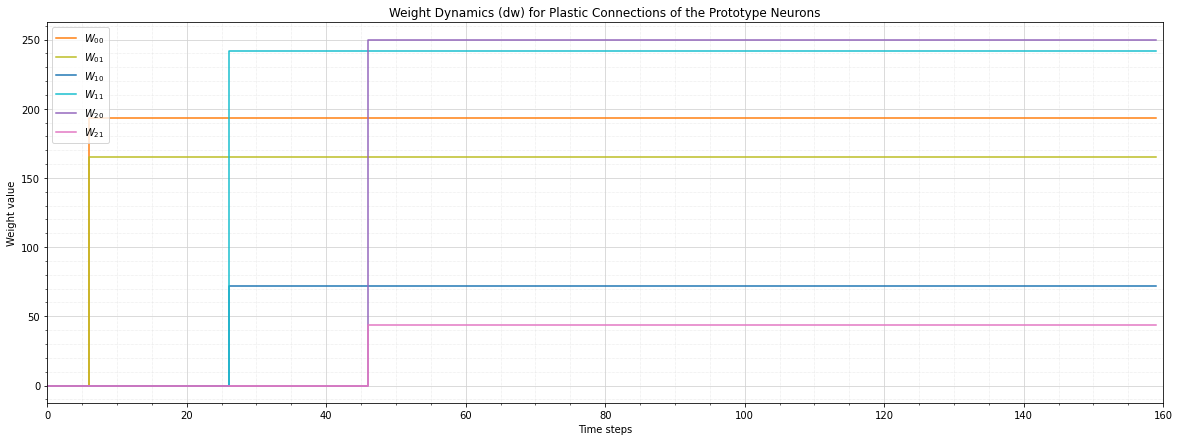

In [22]:
# Plotting weight dynamics
plot_multiple_time_series(time=time, 
                          time_series_list=np.reshape(result_weights, (num_steps,-1)),
                          ylabel="Weight value", 
                          title="Weight Dynamics (dw) for Plastic Connections of the Prototype Neurons", 
                          figsize=(20, 7), 
                          color=['tab:orange', 'tab:olive', 'tab:blue', 'tab:cyan', 'tab:purple', 'tab:pink'], 
                          legend=['$W_{00}$', '$W_{01}$', '$W_{10}$', '$W_{11}$', '$W_{20}$', '$W_{21}$']
                         )

In the above figure, we see the weight dynamics for the input synapses of all three prototype neurons. Evidently, the weights are updated in one-shot after the novelty spike and then stay constant.

In the following cell, we will see what the learned prototypes together with their recognition margins look like. 

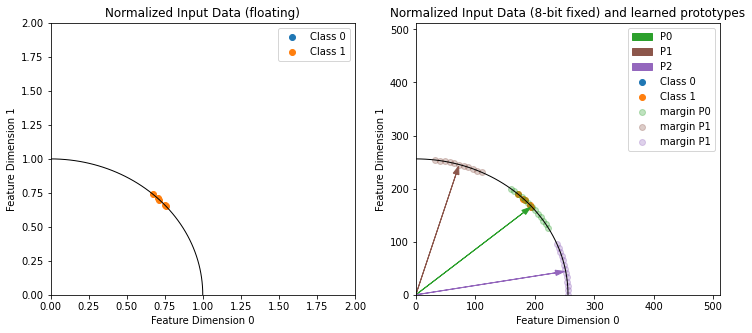

In [20]:
fig, axes = plt.subplots(figsize=(12,5),nrows=1, ncols=2)
plt.sca(axes[0])
plt.scatter(inp_pattern[y==0, 0], inp_pattern[y==0, 1], label="Class 0")
plt.scatter(inp_pattern[y==1, 0], inp_pattern[y==1, 1], label="Class 1")


plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("Feature Dimension 0")
plt.ylabel("Feature Dimension 1")
plt.title("Original Input Data")
plt.legend()

theta = np.linspace(0,np.pi*0.5)
plt.plot(np.cos(theta), np.sin(theta), linewidth=1, c='k')
plt.title("Normalized Input Data (floating)")

w_0 = result_weights[-1,0,:]
w_1 = result_weights[-1,1,:]
w_2 = result_weights[-1,2,:]

plt.sca(axes[1])
plt.scatter(inp_pattern_fixed[y==0, 0], inp_pattern_fixed[y==0, 1], label="Class 0")
plt.scatter(inp_pattern_fixed[y==1, 0], inp_pattern_fixed[y==1, 1], label="Class 1")
plt.arrow(0, 0, w_0[0], w_0[1], label="P0", color = 'tab:green', head_width=10, length_includes_head=True)
plt.arrow(0, 0, w_1[0], w_1[1], label="P1", color = 'tab:brown', head_width=10, length_includes_head=True)
plt.arrow(0, 0, w_2[0], w_2[1], label="P2", color = 'tab:purple', head_width=10, length_includes_head=True)


plt.xlim([0,512])
plt.ylim([0,512])
plt.xlabel("Feature Dimension 0")
plt.ylabel("Feature Dimension 1")

theta = np.linspace(0,np.pi*0.5)[:, None]
xx = 256*np.cos(theta)
yy = 256*np.sin(theta)
examples = np.concatenate((xx, yy),axis=1)
plt.plot(xx, yy, linewidth=1, c='k')

sims_0 = np.dot(examples, w_0)
sims_1 = np.dot(examples, w_1)
sims_2 = np.dot(examples, w_2)

margin_0 = examples[sims_0 > vth]
margin_1 = examples[sims_1 > vth]
margin_2 = examples[sims_2 > vth]

plt.scatter(margin_0[:,0], margin_0[:,1], c='tab:green',alpha=0.3 , label='margin P0')
plt.scatter(margin_1[:,0], margin_1[:,1], c='tab:brown',alpha=0.3, label='margin P1' )
plt.scatter(margin_2[:,0], margin_2[:,1], c='tab:purple',alpha=0.3, label='margin P1' )

plt.title("Normalized Input Data (8-bit fixed) and learned prototypes")

plt.legend()
plt.show()

In the above figure left panel shows the original input data. The right panel shows the learned prototype vectors and their recognition margins on top of this. The margins are transparent circles, while the original data point are the opaque ones. Note that the vectors points to the center of the recognition margins, but not the clusters, as each prototype is learned in one-shot manner from a single input pattern. The extend of the margins are controlled by the voltage threshold parameter of the prototype neurons ```vth```. In the upcoming releases of CLP this parameter will be also adaptive and learned continually. 